<a href="https://colab.research.google.com/drive/1_aH_eI8VhcMtC2gckhdf4ePWYmgpAVSd?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic regression

Linear regression is not perfectly suitable in classification problems. We start with the simplest case - binary classification.

Consider a probabilistic model of the form
$$p(y|x,w) = {\rm Bern}(y|\sigma(w^Tx)) \tag{1}$$
Here $\sigma(\cdot)$ is the sigmoid function
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
and below is a plot of $\sigma(x)$.

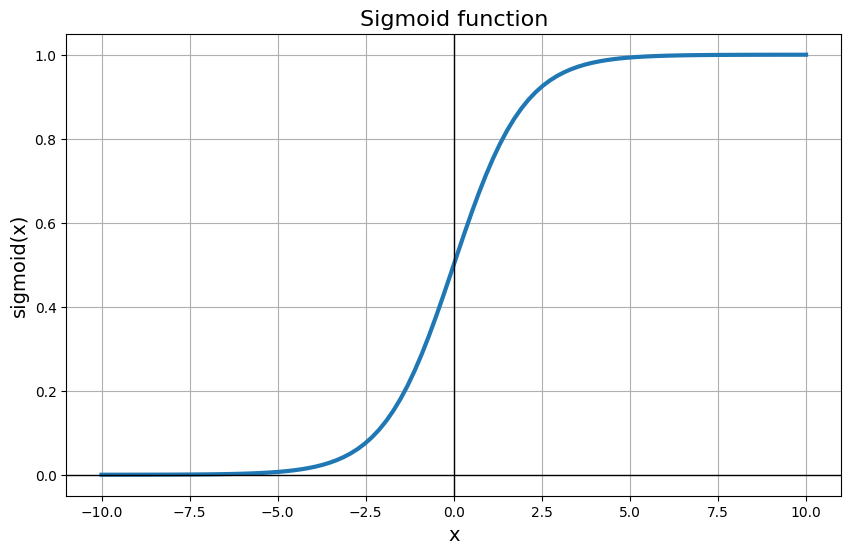

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.figure(figsize=(10, 6))
x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x), lw=3)
plt.title('Sigmoid function', fontsize=16)
plt.grid()
plt.xlabel('x', fontsize=14)
plt.ylabel('sigmoid(x)', fontsize=14)
plt.axvline(0, color='black', lw=1)
plt.axhline(0, color='black', lw=1)
plt.show()

Actually, one could consider any other function that maps real values into (0, 1) interval instead of sigmoid. However, in some sence sigmoid function is a canonical choice. We will discuss it later.

Now let's derive NLL for logistic regression. Denote $\mu_i = \sigma(w^Tx_i)$, then
$$NLL(w) = -\sum_i \log (\mu_i^{I\{y_i=1\}} (1-\mu_i)^{I\{y_i=0\}}) = 
-\sum_i(y_i\log\mu_i + (1-y_i)\log(1-\mu_i)) \, .$$
The last expression is a sum of cross-entropy functions $H(y_i, \mu_i)$.

The NLL minimization problem for logistic regression does not allow closed-form solution. We need to apply some iterative search. The most straightforward idea is a **gradient descent method**.

## Exercise
Show that the gradient of NLL for logistic regression is
$$g(w) = \frac{d}{dw}NLL(w) = X^T({\bf \mu} - {\bf y}) \, ,$$
where $X$ is the matrix in which the i-th row is $x_i$ and ${\bf \mu} = (\mu_1, ..., \mu_N)$.

Now we can implement the iterative procedure
$$w_{n+1} = w_{n} - \lambda g(w_n)$$
where $\lambda$ is the learning rate parameter.

## Numerical experiment

### The Iris dataset

Consider a classification problem constructed from the Iris dataset

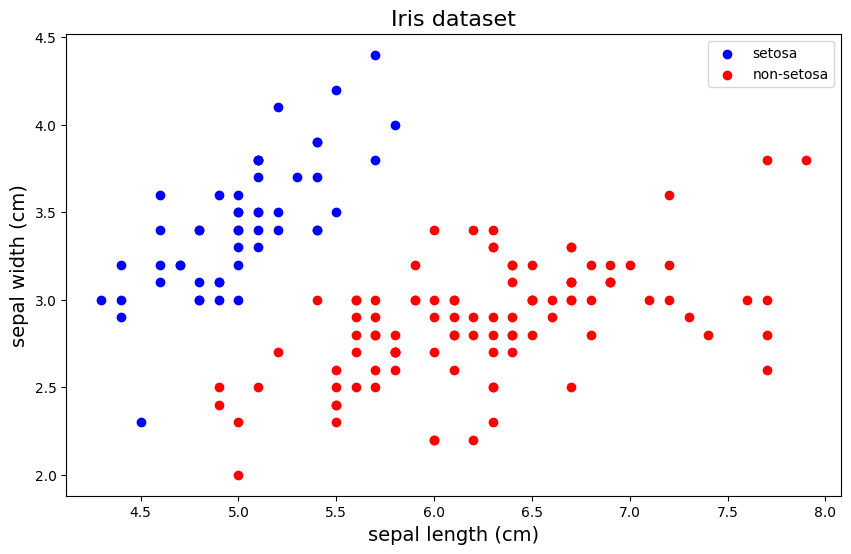

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:, [0, 1]]
y = (iris.target != 0).astype(int)

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='setosa')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='non-setosa')
plt.xlabel('sepal length (cm)', fontsize=14)
plt.ylabel('sepal width (cm)', fontsize=14)
plt.title('Iris dataset', fontsize=16)
plt.legend()
plt.show()

Let's implement a single optimization step:

In [3]:
def grad_step(w, X, y):
    return X.T @ (sigmoid(X @ w) - y) / len(y)

Technical note. We extend features with a constant feature to to add a shift parameter in the linear combination $w^Tx$. 

In [4]:
X = np.hstack([X, np.ones((len(X), 1))])

Split the dataset into train and test parts:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

We start with an arbitrary initial point $w$ and make gradient descent steps. During iterations
we will control the loss function (the cross-entropy) measured on train and test subsets:

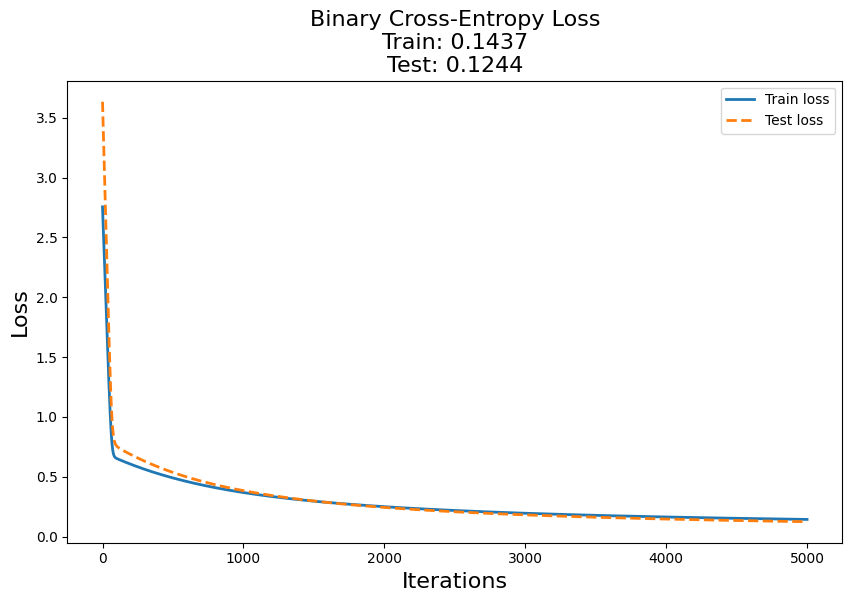

In [6]:
def bce_loss(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))

w = np.array([1, 1, 1])
rate = 0.01

loss_train = []
loss_test = []
for i in range(5000):
    w = w - rate * grad_step(w, X_train, y_train)
    loss_train.append(bce_loss(y_train, sigmoid(X_train @ w)))
    loss_test.append(bce_loss(y_test, sigmoid(X_test @ w)))

plt.figure(figsize=(10, 6))
plt.plot(loss_train, label='Train loss', lw=2)
plt.plot(loss_test, label='Test loss', lw=2, linestyle='--')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title(f'Binary Cross-Entropy Loss\nTrain: {loss_train[-1]:.4f}\nTest: {loss_test[-1]:.4f}', fontsize=16)
plt.legend()
plt.show()

The learned parameters:

In [7]:
w

array([ 2.09785236, -3.57749179,  0.12514119])

Let's visualize a heatmap of predicted scores:

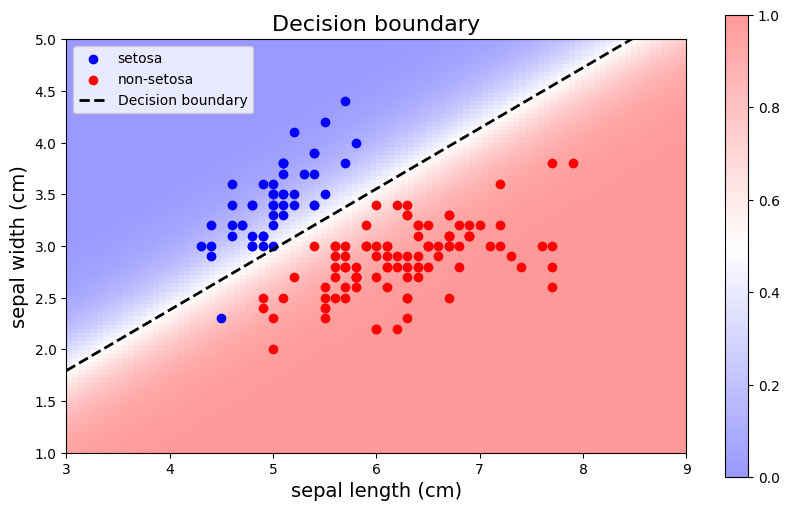

In [8]:
xv, yv = np.meshgrid(np.linspace(3, 9, 100), np.linspace(1, 5, 100))
pts = np.stack([xv, yv]).T
pts = np.dstack([pts, np.ones(pts.shape[:2] + (1,))])

plt.figure(figsize=(10, 6))
im = plt.imshow(sigmoid(pts @ w).T, cmap='bwr', origin='lower',
                extent=[3, 9, 1, 5], alpha=0.4, vmin=0, vmax=1)
# plt.scatter(*X[:, :2].T, c=np.array(['b', 'r'])[y])
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='setosa')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='non-setosa')
plt.colorbar(im)
plt.xlabel('sepal length (cm)', fontsize=14)
plt.ylabel('sepal width (cm)', fontsize=14)
plt.title('Decision boundary', fontsize=16)
# add a line ax + by + c = 0 from w0*x + w1*y + w2 = 0
x_line = np.linspace(3, 9, 100)
y_line = -(w[0]*x_line + w[2]) / w[1]
plt.plot(x_line, y_line, lw=2, color='black', label='Decision boundary', linestyle='--')
plt.ylim(1, 5)
plt.legend()
plt.show()

To convert predicted scores to class labels we threshold scores at 0.5:

In [9]:
y_pred_train = (sigmoid(X_train @ w) > 0.5).astype(int)
y_pred_test = (sigmoid(X_test @ w) > 0.5).astype(int)

Using predicted class labels one can consider additional classification metrics:

In [10]:
from sklearn.metrics import classification_report

print('Train metrics')
print(classification_report(y_train, y_pred_train))

print('Test metrics')
print(classification_report(y_test, y_pred_test))

Train metrics
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.98      1.00      0.99        63

    accuracy                           0.99        90
   macro avg       0.99      0.98      0.99        90
weighted avg       0.99      0.99      0.99        90

Test metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        37

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Note that all metrics are based on a confision matrix:

In [11]:
from sklearn.metrics import confusion_matrix

print('Train metrics')
print(confusion_matrix(y_train, y_pred_train))

print('Test metrics')
print(confusion_matrix(y_test, y_pred_test))

Train metrics
[[26  1]
 [ 0 63]]
Test metrics
[[23  0]
 [ 0 37]]


The ROC curve for our classifier:

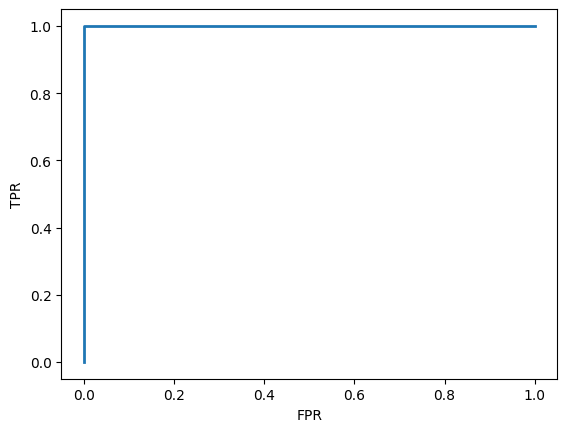

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, sigmoid(X_test @ w))

plt.plot(fpr, tpr, lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Moons dataset

The above data set was linearly separable. That is why the logistic regression was almost perfect. Cosider the more complex problem:

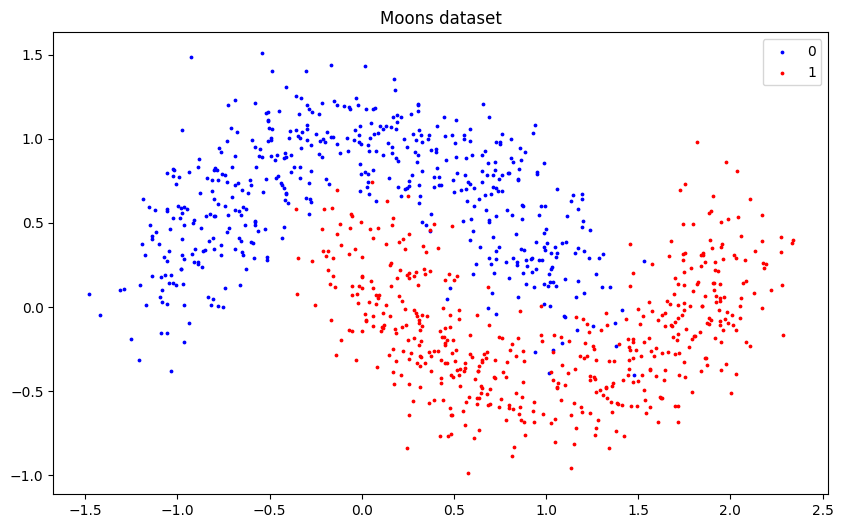

In [13]:
from sklearn.datasets import make_moons

moons_data, moons_labels = make_moons(1000, noise=0.2)
plt.figure(figsize=(10, 6))
plt.scatter(moons_data[moons_labels == 0][:, 0], moons_data[moons_labels == 0][:, 1], color='blue', label='0', s=3)
plt.scatter(moons_data[moons_labels == 1][:, 0], moons_data[moons_labels == 1][:, 1], color='red', label='1', s=3)
plt.legend()
plt.title('Moons dataset')
plt.show()

In [14]:
moons_data = np.hstack([moons_data, np.ones((len(moons_data), 1))])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(moons_data, moons_labels,
                                                    test_size=0.4, random_state=42)

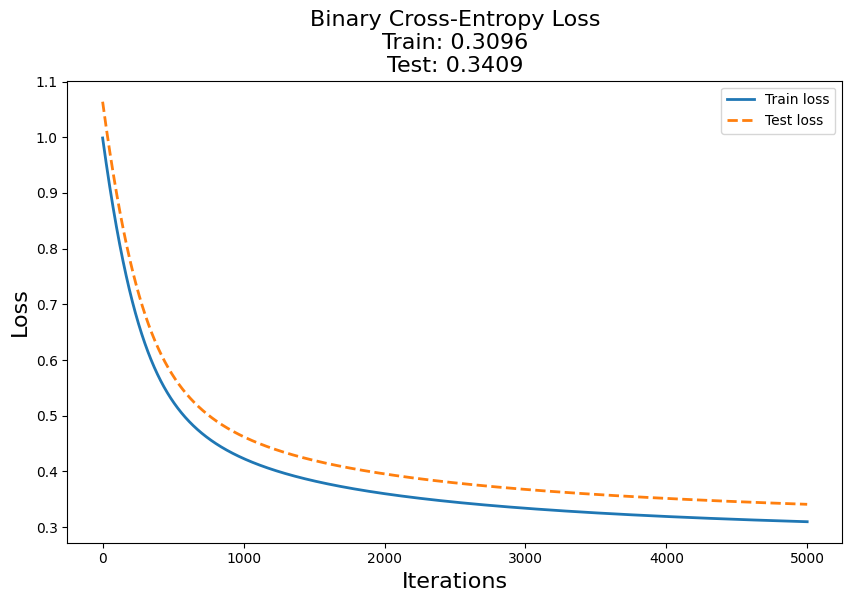

In [16]:
w = np.array([1, 1, 1])
rate = 0.01

loss_train = []
loss_test = []
for i in range(5000):
    w = w - rate * grad_step(w, X_train, y_train)
    loss_train.append(bce_loss(y_train, sigmoid(X_train @ w)))
    loss_test.append(bce_loss(y_test, sigmoid(X_test @ w)))

plt.figure(figsize=(10, 6))
plt.plot(loss_train, label='Train loss', lw=2)
plt.plot(loss_test, label='Test loss', lw=2, linestyle='--')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title(f'Binary Cross-Entropy Loss\nTrain: {loss_train[-1]:.4f}\nTest: {loss_test[-1]:.4f}', fontsize=16)

plt.legend()
plt.show()

Now the results are obviously worse:

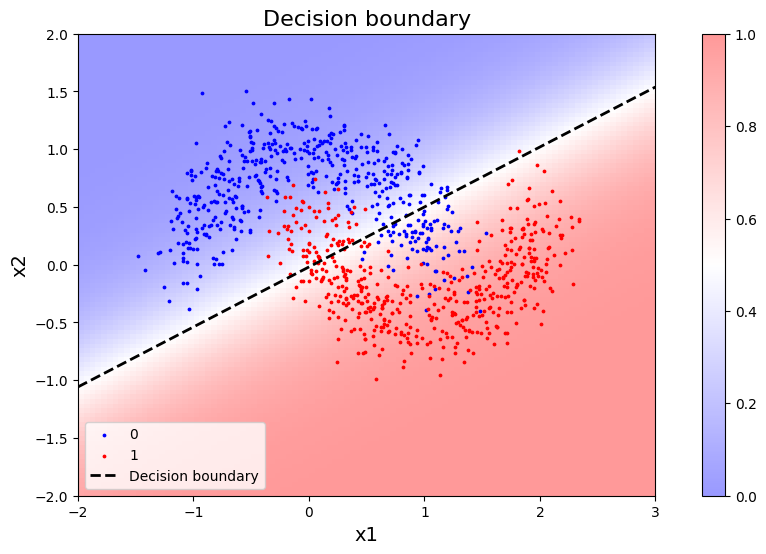

In [17]:
xv, yv = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2, 100))
pts = np.stack([xv, yv]).T
pts = np.dstack([pts, np.ones(pts.shape[:2] + (1,))])

plt.figure(figsize=(12, 6))
im = plt.imshow(sigmoid(pts @ w).T, cmap='bwr', origin='lower',
                extent=[-2, 3, -2, 2], alpha=0.4, vmin=0, vmax=1)
plt.scatter(moons_data[moons_labels == 0][:, 0], moons_data[moons_labels == 0][:, 1], color='blue', label='0', s=3)
plt.scatter(moons_data[moons_labels == 1][:, 0], moons_data[moons_labels == 1][:, 1], color='red', label='1', s=3)
plt.colorbar(im)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.title('Decision boundary', fontsize=16)
# add a line ax + by + c = 0 from w0*x + w1*y + w2 = 0
x_line = np.linspace(-2, 3, 100)
y_line = -(w[0]*x_line + w[2]) / w[1]
plt.plot(x_line, y_line, lw=2, color='black', label='Decision boundary', linestyle='--')
plt.ylim(-2, 2)
plt.legend()
plt.show()

Metrics:

In [18]:
y_pred_train = (sigmoid(X_train @ w) > 0.5).astype(int)
y_pred_test = (sigmoid(X_test @ w) > 0.5).astype(int)

print('Train metrics')
print(classification_report(y_train, y_pred_train))

print('Test metrics')
print(classification_report(y_test, y_pred_test))

Train metrics
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       302
           1       0.84      0.85      0.85       298

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

Test metrics
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       198
           1       0.82      0.85      0.83       202

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



At this point, new (nonlinear) features can help to improve the situation.

In [23]:
X_train2 = np.hstack([X_train[:, :2]**3, X_train[:, :2]**2, X_train])
X_test2 = np.hstack([X_test[:, :2]**3, X_test[:, :2]**2, X_test])

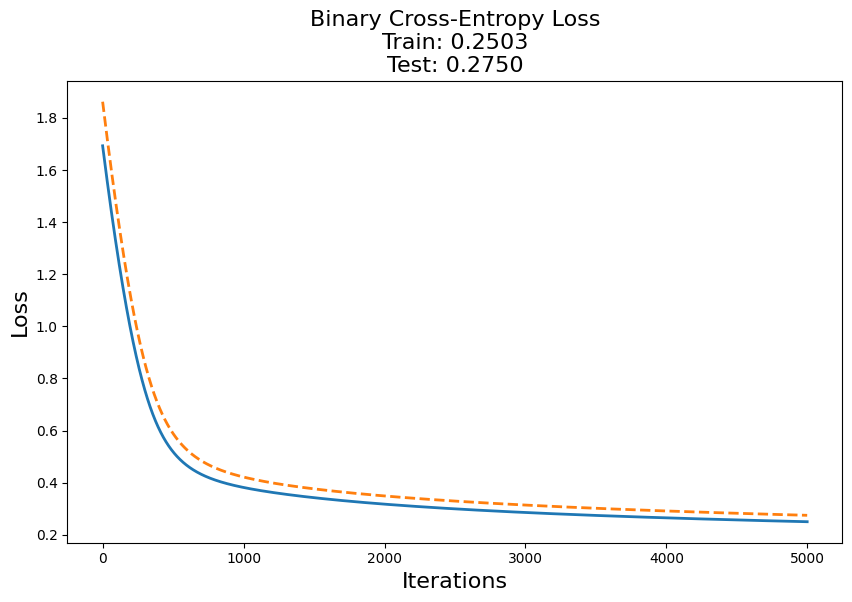

In [25]:
w2 = np.array([1, 1, 1, 1, 1, 1, 1])
rate = 0.01

loss_train = []
loss_test = []
for i in range(5000):
    w2 = w2 - rate * grad_step(w2, X_train2, y_train)
    loss_train.append(bce_loss(y_train, sigmoid(X_train2 @ w2)))
    loss_test.append(bce_loss(y_test, sigmoid(X_test2 @ w2)))

plt.figure(figsize=(10, 6))
plt.plot(loss_train, label='Train loss', lw=2)
plt.plot(loss_test, label='Test loss', lw=2, linestyle='--')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title(f'Binary Cross-Entropy Loss\nTrain: {loss_train[-1]:.4f}\nTest: {loss_test[-1]:.4f}', fontsize=16)
plt.show()

We obtain better resutls:

In [26]:
xv, yv = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2, 100))
pts = np.stack([xv, yv]).T
pts = np.dstack([pts, np.ones(pts.shape[:2] + (1,))])


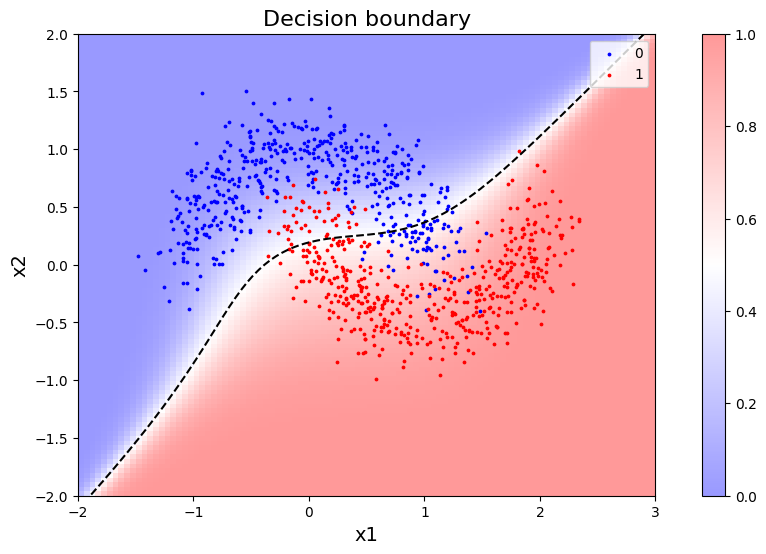

In [28]:

plt.figure(figsize=(12, 6))
im = plt.imshow(
    sigmoid(np.dstack([pts[..., :2]**3, pts[..., :2]**2, pts]) @ w2).T,
    cmap='bwr',
    origin='lower',
    extent=[-2, 3, -2, 2],
    alpha=0.4,
    vmin=0,
    vmax=1
)

plt.scatter(
    moons_data[moons_labels == 0][:, 0],
    moons_data[moons_labels == 0][:, 1],
    color='blue',
    label='0',
    s=3
)
plt.scatter(
    moons_data[moons_labels == 1][:, 0],
    moons_data[moons_labels == 1][:, 1],
    color='red',
    label='1',
    s=3
)

plt.colorbar(im)

plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.title('Decision boundary', fontsize=16)
plt.contour(
    xv,
    yv,
    sigmoid(
        np.dstack([pts[..., :2]**3, pts[..., :2]**2, pts]) @ w2
    ).T,
    levels=[0.5],
    colors='black',
    linestyles='--'
)
plt.legend()
plt.show()

Metrics have improved:

In [29]:
y_pred_train = (sigmoid(X_train2 @ w2) > 0.5).astype(int)
y_pred_test = (sigmoid(X_test2 @ w2) > 0.5).astype(int)

print('Train metrics')
print(classification_report(y_train, y_pred_train))

print('Test metrics')
print(classification_report(y_test, y_pred_test))

Train metrics
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       302
           1       0.87      0.90      0.89       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.88       600
weighted avg       0.89      0.89      0.88       600

Test metrics
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       198
           1       0.85      0.92      0.88       202

    accuracy                           0.88       400
   macro avg       0.88      0.87      0.87       400
weighted avg       0.88      0.88      0.87       400



Compare the classifiers with and without the new features:

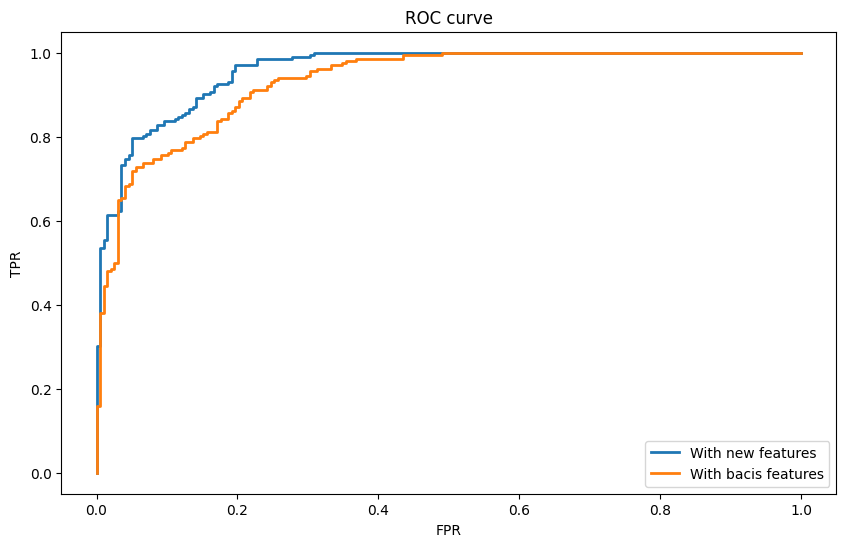

In [30]:
plt.figure(figsize=(10, 6))

fpr, tpr, thresholds = roc_curve(y_test, sigmoid(X_test2 @ w2))
plt.plot(fpr, tpr, lw=2, label='With new features')

fpr, tpr, thresholds = roc_curve(y_test, sigmoid(X_test @ w))
plt.plot(fpr, tpr, lw=2, label='With bacis features')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()